In [1]:
# Dataset configuration
_DATA_PATH = "/workspace/data/test/train"
_CLIP_DURATION = 4 # Duration of sampled clip for each video
_BATCH_SIZE = 2
_NUM_WORKERS = 4  # Number of parallel processes fetching data

In [2]:
class opt:
    _DATA_PATH = "/workspace/data/test/train"
    _CLIP_DURATION = 10 # Duration of sampled clip for each video
    _BATCH_SIZE = 10
    _NUM_WORKERS = 4  # Number of parallel processes fetching data

In [3]:
from typing import Any, Callable, Dict, Optional, Type

import torch 
import pytorchvideo
from pytorchvideo.data.clip_sampling import ClipSampler

from pytorchvideo.data.labeled_video_dataset import LabeledVideoDataset, labeled_video_dataset

In [4]:
def WalkDataset(
    data_path: str,
    clip_sampler: ClipSampler,
    video_sampler: Type[torch.utils.data.Sampler] = torch.utils.data.RandomSampler,
    transform: Optional[Callable[[Dict[str, Any]], Dict[str, Any]]] = None,
    video_path_prefix: str = "",
    decode_audio: bool = False,
    decoder: str = "pyav",
) -> LabeledVideoDataset:
    '''
    A helper function to create "LabeledVideoDataset" object for the Walk dataset.

    Args:
        data_path (str): Path to the data. The path defines how the data should be read. For a directory, the directory structure defines the classes (i.e. each subdirectory is class).
        clip_sampler (ClipSampler): Defines how clips should be sampled from each video. See the clip sampling documentation for more information.
        video_sampler (Type[torch.utils.data.Sampler], optional): Sampler for the internal video container. Defaults to torch.utils.data.RandomSampler.
        transform (Optional[Callable[[Dict[str, Any]], Dict[str, Any]]], optional): This callable is evaluated on the clip output before the clip is returned. Defaults to None.
        video_path_prefix (str, optional): Path to root directory with the videos that are
                loaded in ``LabeledVideoDataset``. Defaults to "".
        decode_audio (bool, optional): If True, also decode audio from video. Defaults to False. Notice that, if Ture will trigger the stack error.
        decoder (str, optional): Defines what type of decoder used to decode a video. Defaults to "pyav".

    Returns:
        LabeledVideoDataset: _description_
    '''
    return labeled_video_dataset(
        data_path,
        clip_sampler,
        video_sampler,
        transform,
        video_path_prefix,
        decode_audio,
        decoder
    )


In [5]:
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip
)

In [6]:

transform = Compose(
        [
        ApplyTransformToKey(
          key="video",
          transform=Compose(
              [
                UniformTemporalSubsample(8),
                Lambda(lambda x: x / 255.0),
                Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
                RandomShortSideScale(min_size=256, max_size=320),
                RandomCrop(244),
                RandomHorizontalFlip(p=0.5),
              ]
            ),
          ),
        ]
    )


In [7]:
dataset = WalkDataset(
    data_path=_DATA_PATH,
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", _CLIP_DURATION),
    # clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", _CLIP_DURATION),
    decode_audio=False,
    transform=transform
)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = _BATCH_SIZE,
    num_workers=_NUM_WORKERS
)

In [8]:
# # iter_data_loader = iter(data_loader)
# # 完成
# data = {"video": [], "class": [], 'tensorsize': []}
# num_batch = 0
# for num, batch in enumerate(data_loader):
#     for i in range(data_loader.batch_size):
#         data['video'].append(batch['video_name'][i])
#         data['class'].append(batch['label'][i])
#         data['tensorsize'].append(batch['video'][i].size())
#     num_batch += 1

# print('finish' + str(num_batch))
# print(data)


In [9]:
class WalkDataModule():
    def __init__(self, opt):
        super().__init__()
        self._DATA_PATH = opt._DATA_PATH
        self._CLIP_DURATION = opt._CLIP_DURATION
        self._BATCH_SIZE = opt._BATCH_SIZE
        self._NUM_WORKERS = opt._NUM_WORKERS
    
    def train_dataloader(self):
        '''
        create the Walk train partition from the list of video labels 
        in directory and subdirectory. Add transform that subsamples and 
        normalizes the video before applying the scale, crop and flip augmentations.
        '''        
        train_transform = Compose(
            [
                ApplyTransformToKey(
                    key="video",
                    transform=Compose(
                        [
                            UniformTemporalSubsample(8),
                            Lambda(lambda x: x / 255.0),
                            Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
                            RandomShortSideScale(min_size=256, max_size=320),
                            RandomCrop(244),
                            RandomHorizontalFlip(p=0.5),
                        ]
                    ),
                ),
            ]
        )

        train_dataset = WalkDataset(
            data_path=self._DATA_PATH,
            clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
            transform=train_transform
        )

        return torch.utils.data.DataLoader(
            train_dataset,
            batch_size = self._BATCH_SIZE,
            num_workers = self._NUM_WORKERS,
        )

In [10]:
data_module = WalkDataModule(opt).train_dataloader()

x = next(iter(data_module))

In [11]:
x['video_name'][0]

data = {"video": [], "class": [], 'tensorsize': []}

data['video'].append(x['video_name'][0])

data_module.batch_size

10

In [32]:
data = {"video": [], "class": [], 'tensorsize': []}

for num, batch in enumerate(data_module):
    for i in range(len(batch['video_index'].tolist())): # 计算当前batch中的video个数
        data['video'].append(batch['video_name'][i])
        data['class'].append(batch['label'][i])
        data['tensorsize'].append(batch['video'][i].size())

print('finish batch' + str(num))
print(data)


finish batch7
{'video': ['ca11.mp4', 'ca6.mp4', 'ca24.mp4', 'ca28.mp4', 'ca41.mp4', 'c10.mp4', 'ca35.mp4', 'ca12.mp4', 'ca15.mp4', 'ca36.mp4', 'ca19.mp4', 'c3.mp4', 'ca31.mp4', 'ca34.mp4', 'ca40.mp4', 'ca3.mp4', 'full_ap_edited.mp4', 'ca13.mp4', 'full_lat.MP4', 'c6.mp4', 'c5.mp4', 'c2.mp4', 'ca16.mp4', 'ca7.mp4', 'ca1.mp4', 'c4.mp4', 'ca37.mp4', 'ca21.mp4', 'c7.mp4', 'ca2.mp4', 'ca39.mp4', 'ca42.mp4', 'ca25.mp4', 'ca20.mp4', 'ca38.mp4', 'ca30.mp4', 'c8.mp4', 'ca29.mp4', 'ca43.mp4', 'ca32.mp4', 'ca8.mp4', 'c9.mp4', 'ca33.mp4', 'ca10.mp4', 'c14.mp4', 'ca17.mp4', 'ca5.mp4', 'c12.mp4', 'ca4.mp4', 'c11.mp4', 'ca18.mp4', 'ca14.mp4', 'ca9.mp4', 'ca27.mp4', 'ca26.mp4', 'full_lat.mp4', 'c13.mp4', 'ca22.mp4', 'ca23.mp4', 'full_lat_edited.mp4'], 'class': [tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(0), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(0), tensor(3), tensor(3), tensor(3), tensor(3), tensor(2), tensor(3), tensor(2), tensor(0), tensor(0), tensor(0), ten

In [79]:
batch["video"][0].permute(1, 2, 3, 0)[0].shape

batch['video'].shape


torch.Size([5, 3, 8, 244, 244])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

full_lat.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

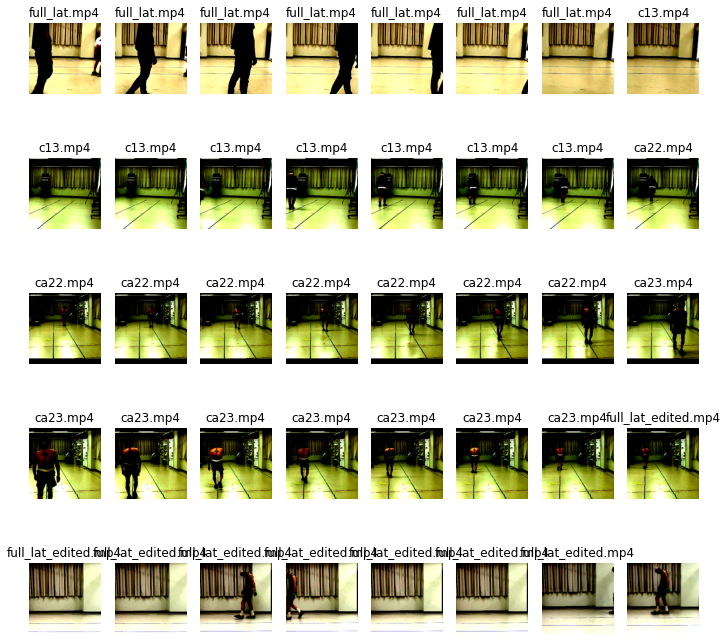

In [77]:
import matplotlib.pylab as plt 

print(batch['video_name'][0])

location = 1

plt.figure(figsize=(12, 12))

for num in range(len(batch['video_index'])): # batch size
    for i in range(batch['video'].size()[2]): # 帧数
        plt.title(batch['video_name'][num])
        plt.subplot(len(batch['video_index']), batch['video'].size()[2], location)
        plt.imshow(batch["video"][num].permute(1, 2, 3, 0)[i])

        location += 1
        plt.axis("off")

plt.show()

